# Similar User Grouping

In [1]:
from Funcs.Utility import *
PATH_SAVE = '/var/nfs_share/Stress_Detection_D-1/Intermediate/Multi_task/'

In [2]:
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc','LABELS_PROC.csv'), index_col=['pcode','timestamp'],parse_dates=True)
PARTICIPANTS = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'PARTICIPANT_INFO.csv'),index_col = 'pcode')

# Data Splitting

In [3]:
p = os.path.join(PATH_INTERMEDIATE, 'feat', 'stress-fixed.pkl')
X, y, groups, t, datetimes = load(p)

In [4]:
# #The following code is for excluding using 1st day
# ###########################################
# filtered_df = pd.read_csv(os.path.join(PATH_INTERMEDIATE,'exclude_1st_day.csv'),index_col=0)
# X_filtered = X[X.index.isin(filtered_df.index)]
# y_series = pd.Series(y, index=X.index)
# y_filtered = y_series[y_series.index.isin(filtered_df.index)]
# y_filtered = y_filtered.values
# groups_series = pd.Series(groups, index=X.index)
# groups_filtered = groups_series[groups_series.index.isin(filtered_df.index)]
# groups_filtered = groups_filtered.values
# X,y, groups=X_filtered,y_filtered, groups_filtered

In [4]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [5]:
# #The following code is for calculating aggregated features
# #######################################################################
# #Define a function to split the column name into sensor and attribute
# def split_column_name(col_name):
#     parts = col_name.rsplit("#", 1)  # Split on last occurrence of '#'
#     return parts[0]  # This gives you 'Sensor#Attribute'

# # Get a list of unique sensor-attribute combinations
# df=feat_yesterday_sensor
# sensor_attributes = df.columns.map(split_column_name).unique()

# # Create a list to hold the aggregated results
# agg_results = []

# # Loop over each sensor-attribute, select the appropriate columns, compute the mean and std
# for sensor_attribute in sensor_attributes:
#     # Select columns for this sensor-attribute
#     cols_to_aggregate = [col for col in df.columns if col.startswith(sensor_attribute)]
#     # Compute the mean and std and store in the new DataFrame
#     agg_results.append(df[cols_to_aggregate].mean(axis=1).rename(sensor_attribute + '|'+ 'MEAN'))
#     agg_results.append(df[cols_to_aggregate].std(axis=1).rename(sensor_attribute + '|'+'STD'))

# # Concatenate all the results into a single DataFrame
# agg_feature = pd.concat(agg_results, axis=1)
# # # Replace inf and -inf with NaN
# # agg_feature.replace([np.inf, -np.inf], np.nan, inplace=True)
# # agg_feature = agg_feature.fillna(0)

In [6]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)

# # Fill NaN values with zeros
# feat_final = feat_final.fillna(0)

# # Find the maximum non-infinity value and minimum non-negative infinity value across the entire dataframe
# max_val = feat_final[feat_final != np.inf].max().max()
# min_val = feat_final[feat_final != -np.inf].min().min()

# # Replace positive and negative infinity values
# feat_final.replace(np.inf, max_val, inplace=True)
# feat_final.replace(-np.inf, min_val, inplace=True)


X = feat_final
cats = X.columns[X.dtypes == bool]

In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

normalize =True
# Feature selection method
selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )  
    )
select = [clone(selector)]
oversample = True

In [8]:
def process_dataframe(X):
    """
    Process the input DataFrame 'X':
    1. Set column names as a range from 0 to the number of columns.
    2. Replace boolean values with 1 for True and 0 for False.

    Parameters:
        X (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The processed DataFrame.
    """
    # Set column names as a range from 0 to the number of columns
    X.columns = range(X.shape[1])

    # Replace boolean values with 1 for True and 0 for False
#     X = X * 1

    return X

def save_data_to_data_file(X, y, filename):
    if not os.path.exists(PATH_SAVE):
        os.makedirs(PATH_SAVE)

    file_path = os.path.join(PATH_SAVE, filename)

    with open(file_path, 'w') as f:
        for i in range(len(X)):
            # Check if y is a numpy array or dataframe
            label = y[i] if isinstance(y, np.ndarray) else y.iloc[i].values[0]
            
            # Start building the line with the label
            line = str(label)
            
            # Iterate through columns of X
            for col_idx, value in enumerate(X[i] if isinstance(X, np.ndarray) else X.iloc[i]):
                line += " {}:{}".format(col_idx, value)
            
            f.write(line + '\n')


In [9]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test



# @ray.remote
# # def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
# def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file):
#     X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    
# #     # Use LOSO to split the training set further into training and evaluation sets
# #     loso = LeaveOneGroupOut()
# #     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
# #     X_eval, y_eval = X_train.iloc[eval_indices], y_train[eval_indices]
# #     X_train, y_train = X_train.iloc[train_indices], y_train[train_indices]
    
#     # Split 20% of training set as eval set
#     X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# #     # Split 20% of training set as eval set based on groups
# #     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
# #     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
# #     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
# #     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]
    
#     # Apply SMOTENC
#     smote_nc = SMOTENC(categorical_features=get_categorical_features_indices(X_train), random_state=RANDOM_STATE)
#     X_train, y_train = smote_nc.fit_resample(X_train, y_train)
    
# #     #Removing low variance features
# #     X_train = exclude_low_variance(X_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

# #     #Removing highly correlated features
# #     X_train = remove_pairwise_corr(X_train, outcome_variable= y_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set
    
#     # Capture indices 
#     train_indices = X_train.index
#     eval_indices = X_eval.index
#     test_indices = X_test.index
    
#     # Before feature selection, capture the columns
#     current_columns = X_train.columns
    
#     # Feature selection
#     selector = feature_selector(X_train, y_train)
#     X_train = selector.transform(X_train)
#     X_eval = selector.transform(X_eval)
#     X_test = selector.transform(X_test)

#     # Use the captured columns to get the selected columns
#     selected_columns = current_columns[selector.get_support()]
    
#     X_train = pd.DataFrame(X_train, columns=selected_columns, index=train_indices)
#     X_eval = pd.DataFrame(X_eval, columns=selected_columns, index=eval_indices)
#     X_test = pd.DataFrame(X_test, columns=selected_columns, index=test_indices)

    
#     # Process dataframes
#     X_train = process_dataframe(X_train)
#     X_eval = process_dataframe(X_eval)
#     X_test = process_dataframe(X_test)

#     subject = all_groups[test_idx[0]]

#     save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
#     save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
#     save_data_to_data_file(X_test, y_test, f'{subject}_val.data')

@ray.remote
def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
    X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    

#     #Leave n subject out
#     n = 4  # Number of groups to leave out
#     # Use LNGO to split the training set further into training and evaluation sets
#     lngo = LeavePGroupsOut(n_groups=n)
#     train_indices, eval_indices = next(lngo.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()

    
#     # Use LOSO to split the training set further into training and evaluation sets
#     loso = LeaveOneGroupOut()
#     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()


#     # Initialize the stratified group k-fold splitter
#     sgkf = StratifiedGroupKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
#     # Get the train and eval indices
#     train_inds, eval_inds = next(sgkf.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    
    # Split 20% of training set as eval set
    X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE,  stratify=y_train)

#     # Split 20% of training set as eval set based on groups
#     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
#     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    if normalize:
        # Normalize numeric features
        scaler = StandardScaler().fit(X_train[C_num])
        X_train[C_num] = scaler.transform(X_train[C_num].copy())
        X_eval[C_num] = scaler.transform(X_eval[C_num].copy())
        X_test[C_num] = scaler.transform(X_test[C_num].copy())

    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            # Fit feature selector only on training data
            s.fit(X_train, y_train)
            selected_features = X_train.columns[s.get_support()]
            
            # Apply feature selection to train, eval, and test
            X_train = X_train[selected_features].copy()
            X_eval = X_eval[selected_features].copy()
            X_test = X_test[selected_features].copy()

    if oversample:
        # Determine categorical features for SMOTENC
        if len(C_cat):
            M = np.isin(X_train.columns, C_cat)
            sampler = SMOTENC(categorical_features=M, random_state=seed)
        else:
            sampler = SMOTE(random_state=seed)
        # Only oversample training data
        X_train, y_train = sampler.fit_resample(X_train, y_train)
    
    # Apply consistent processing to train, eval, and test dataframes
    X_train = process_dataframe(X_train)
    X_eval = process_dataframe(X_eval)
    X_test = process_dataframe(X_test)

    subject = all_groups[test_idx[0]]

    # Save processed data to files
    save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
    save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
    save_data_to_data_file(X_test, y_test, f'{subject}_val.data')


In [10]:
# Create a full dataset and corresponding labels and groups
all_data = X
all_labels = y
all_groups = groups

In [11]:


cv_strategy = 'loso'  # Choose from: 'loso', 'group_k_fold', 'k_fold', 'time_series'

with on_ray():
    # Get the relevant train-test splits based on the chosen CV strategy
    splits = get_cv_splits(cv_strategy, all_data, all_labels, all_groups)
    
    C_cat = np.asarray(sorted(cats))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))
#    Iterate over train-test splits
    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select) 
#    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file)
                                         for train_idx, test_idx in splits]

    ray.get(futures)

2023-11-08 05:24:32,223	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-11-08 05:24:32,263	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
(process_and_save_split pid=28419) /tmp/ipykernel_30820/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=28419) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=28419) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=28419) 
(process_and_save_split pid=28419) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_and_save_split pid=30990) /tmp/ipykernel_30820/632661198.py:203: SettingWithCopyWarning:  [repeated 28x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ra

# Model Training & Evaluation

In [12]:
from Funcs.Utility import *
PATH_SAVE = '/var/nfs_share/Stress_Detection_D-1/Intermediate/Multi_task/'

PATH_RESULTS = '/var/nfs_share/Stress_Detection_D-1/Results/'

In [13]:
# param = {
#     "predictor": 'cpu_predictor',
#     "colsample_bytree": 0.8,
# #     "colsample_bylevel": 1,
# #     "scale_pos_weight": 1,
#     "learning_rate": 0.01,
#     "min_child_weight": 1.5,
#     "subsample": 0.8,
#     "reg_lambda": 2, #default 1, best 20
#     "reg_alpha":1, #best 
#     "seed": seed,
#     "objective": 'binary:logistic',
#     "max_depth": 6,
#     "gamma": 2,
#     'eval_metric': 'auc',
#     'verbosity': 0,
#     'tree_method': 'gpu_hist', #'hist' or 'exact'
# }

param = {
    "learning_rate": 0.01,
    "seed": RANDOM_STATE,
    "objective": 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
}

In [14]:
import xgboost as xgb
import random
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             log_loss, accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)
import numpy as np
import os
import pickle
import ray
import pandas as pd
from sklearn.datasets import load_svmlight_file
from xgboost import DMatrix


def mkdir(path):
    path = path.strip()
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False

def find_best_threshold(y_true, y_probs):
    best_threshold = 0
    best_f1 = 0
    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    return best_threshold

random.seed(seed)

folder = PATH_RESULTS
mkdir(folder)
data_folder = PATH_SAVE

final_total_auc = np.empty(0)
final_total_logloss = np.empty(0)
final_total_f1_macro = np.empty(0)
final_total_f1_pos_label = np.empty(0)
final_total_accuracy = np.empty(0)
final_total_precision = np.empty(0)
final_total_recall = np.empty(0)
train_aucs = []
test_aucs = []



# @ray.remote
def train_and_evaluate(subject, param, data_folder):

    print("start training & evaluation for {}".format(subject))


    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(data_folder + '{}_train.data'.format(subject))
    dtest = xgb.DMatrix(data_folder + '{}_val.data'.format(subject))
    deval = xgb.DMatrix(data_folder + '{}_eval.data'.format(subject))
    

    evallist = [(dtrain, 'train'), (deval, 'eval')]

    # Train the model using standard xgboost
    bst = xgb.train(param, dtrain, evals=evallist, early_stopping_rounds=10)
    
    y_real = dtest.get_label()  # Use the labels directly
    y_score = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
#     y_score = bst.predict(dtest)
#     best_threshold = find_best_threshold(y_real, y_score)
#     y_pred = [1 if score >= best_threshold else 0 for score in y_score]
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]

    all_roc_auc = roc_auc_score(y_true=y_real, y_score=y_score, average=None)
    all_logloss = log_loss(y_real, y_score)
    accuracy = accuracy_score(y_real, y_pred)

    pre, rec, f1, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='macro', zero_division=0)
    precision = pre
    recall = rec
    f1_macro = f1

    _, _, f1_pos, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='binary', zero_division=0)
    f1_pos_label = f1_pos
    print("finish training & evaluation for {}".format(subject))

#     return subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label

    ###############################
    # Compute training AUC
    y_train_real = dtrain.get_label()
    y_train_score = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit)
    train_auc = roc_auc_score(y_true=y_train_real, y_score=y_train_score)
    
    test_auc = all_roc_auc

    return subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label
 
with on_ray():
    results = [train_and_evaluate(subject, param, data_folder) for subject in set(all_groups)]
#     futures = [train_and_evaluate.remote(subject, param, data_folder) for subject in combined_similarity['pcode'].unique()]
#     results = ray.get(futures)

    for result in results:
         #Retrieving training AUC
        subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        train_aucs.append(train_auc)
        test_aucs.append(test_auc)
        
#         subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        # Append to final metric arrays
#         final_total_auc = np.append(final_total_auc, all_roc_auc)

        final_total_logloss = np.append(final_total_logloss, all_logloss)
        final_total_accuracy = np.append(final_total_accuracy, accuracy)
        final_total_precision = np.append(final_total_precision, precision)
        final_total_recall = np.append(final_total_recall, recall)
        final_total_f1_macro = np.append(final_total_f1_macro, f1_macro)
        final_total_f1_pos_label = np.append(final_total_f1_pos_label, f1_pos_label)

    print("TOTAL All round, ROCAUC{}, LOGLOSS{}, ACCURACY{}, PRECISION{}, RECALL{}, F1 MACRO{}, F1 POSITIVE LABEL{},\n".format(np.mean(test_aucs), np.mean(final_total_logloss), np.mean(final_total_accuracy), np.mean(final_total_precision), np.mean(final_total_recall), np.mean(final_total_f1_macro), np.mean(final_total_f1_pos_label)))

2023-11-08 05:26:38,371	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-11-08 05:26:38,384	INFO worker.py:1612 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


start training & evaluation for P23
[0]	train-auc:0.84432	eval-auc:0.66909
[1]	train-auc:0.84970	eval-auc:0.67043
[2]	train-auc:0.85528	eval-auc:0.66925
[3]	train-auc:0.85727	eval-auc:0.67034
[4]	train-auc:0.85774	eval-auc:0.67276
[5]	train-auc:0.86062	eval-auc:0.67168
[6]	train-auc:0.86324	eval-auc:0.67607
[7]	train-auc:0.86488	eval-auc:0.67566
[8]	train-auc:0.86686	eval-auc:0.67567
[9]	train-auc:0.86877	eval-auc:0.67642
finish training & evaluation for P23
start training & evaluation for P32
[0]	train-auc:0.83927	eval-auc:0.59375
[1]	train-auc:0.84277	eval-auc:0.61032
[2]	train-auc:0.85434	eval-auc:0.62286
[3]	train-auc:0.85264	eval-auc:0.61791
[4]	train-auc:0.86081	eval-auc:0.61791


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[5]	train-auc:0.87187	eval-auc:0.62885
[6]	train-auc:0.87087	eval-auc:0.62833
[7]	train-auc:0.87458	eval-auc:0.63048
[8]	train-auc:0.87443	eval-auc:0.62996
[9]	train-auc:0.88594	eval-auc:0.63283
finish training & evaluation for P32
start training & evaluation for P39
[0]	train-auc:0.85762	eval-auc:0.60233
[1]	train-auc:0.86747	eval-auc:0.63021
[2]	train-auc:0.87624	eval-auc:0.62616
[3]	train-auc:0.87598	eval-auc:0.63143
[4]	train-auc:0.87763	eval-auc:0.62720
[5]	train-auc:0.88184	eval-auc:0.63111
[6]	train-auc:0.88321	eval-auc:0.63053
[7]	train-auc:0.88857	eval-auc:0.63259
[8]	train-auc:0.89388	eval-auc:0.64471
[9]	train-auc:0.89580	eval-auc:0.64232


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P39
start training & evaluation for P57
[0]	train-auc:0.84382	eval-auc:0.59836
[1]	train-auc:0.84960	eval-auc:0.60320
[2]	train-auc:0.85301	eval-auc:0.60619
[3]	train-auc:0.85730	eval-auc:0.60570
[4]	train-auc:0.85929	eval-auc:0.60306
[5]	train-auc:0.85903	eval-auc:0.60442
[6]	train-auc:0.86173	eval-auc:0.60419
[7]	train-auc:0.86757	eval-auc:0.60787
[8]	train-auc:0.87247	eval-auc:0.60960
[9]	train-auc:0.87777	eval-auc:0.61388
finish training & evaluation for P57
start training & evaluation for P45


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.84932	eval-auc:0.64955
[1]	train-auc:0.85502	eval-auc:0.65880
[2]	train-auc:0.86078	eval-auc:0.65663
[3]	train-auc:0.86433	eval-auc:0.66560
[4]	train-auc:0.86249	eval-auc:0.65893
[5]	train-auc:0.86278	eval-auc:0.65957
[6]	train-auc:0.86666	eval-auc:0.65729
[7]	train-auc:0.86829	eval-auc:0.66172
[8]	train-auc:0.87082	eval-auc:0.66560
[9]	train-auc:0.87250	eval-auc:0.66736
finish training & evaluation for P45
start training & evaluation for P03
[0]	train-auc:0.85271	eval-auc:0.59651
[1]	train-auc:0.85349	eval-auc:0.60075
[2]	train-auc:0.85656	eval-auc:0.60471
[3]	train-auc:0.85882	eval-auc:0.60910
[4]	train-auc:0.85964	eval-auc:0.60777
[5]	train-auc:0.86199	eval-auc:0.61269
[6]	train-auc:0.87322	eval-auc:0.63115
[7]	train-auc:0.87292	eval-auc:0.62710


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-auc:0.87923	eval-auc:0.62685
[9]	train-auc:0.88566	eval-auc:0.63683
finish training & evaluation for P03
start training & evaluation for P06
[0]	train-auc:0.85259	eval-auc:0.62155
[1]	train-auc:0.85398	eval-auc:0.61974
[2]	train-auc:0.85749	eval-auc:0.62369
[3]	train-auc:0.86669	eval-auc:0.63596
[4]	train-auc:0.87590	eval-auc:0.63803
[5]	train-auc:0.87796	eval-auc:0.63941
[6]	train-auc:0.88293	eval-auc:0.64307
[7]	train-auc:0.88255	eval-auc:0.64234
[8]	train-auc:0.88608	eval-auc:0.64777
[9]	train-auc:0.88937	eval-auc:0.64832
finish training & evaluation for P06
start training & evaluation for P40


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.84982	eval-auc:0.58897
[1]	train-auc:0.85057	eval-auc:0.58896
[2]	train-auc:0.85093	eval-auc:0.58876
[3]	train-auc:0.85439	eval-auc:0.59213
[4]	train-auc:0.85812	eval-auc:0.59881
[5]	train-auc:0.86267	eval-auc:0.60272
[6]	train-auc:0.86524	eval-auc:0.60486
[7]	train-auc:0.86998	eval-auc:0.60420
[8]	train-auc:0.87584	eval-auc:0.60527
[9]	train-auc:0.88213	eval-auc:0.60889
finish training & evaluation for P40
start training & evaluation for P60
[0]	train-auc:0.82761	eval-auc:0.61888
[1]	train-auc:0.83107	eval-auc:0.62579
[2]	train-auc:0.84877	eval-auc:0.63144
[3]	train-auc:0.84764	eval-auc:0.62791
[4]	train-auc:0.86094	eval-auc:0.63495
[5]	train-auc:0.86892	eval-auc:0.64031
[6]	train-auc:0.86975	eval-auc:0.64423
[7]	train-auc:0.87482	eval-auc:0.64657
[8]	train-auc:0.87775	eval-auc:0.64504


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[9]	train-auc:0.88340	eval-auc:0.64444
finish training & evaluation for P60
start training & evaluation for P42
[0]	train-auc:0.84257	eval-auc:0.57198
[1]	train-auc:0.84666	eval-auc:0.57500


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.84638	eval-auc:0.57156
[3]	train-auc:0.84621	eval-auc:0.57412
[4]	train-auc:0.84615	eval-auc:0.57502
[5]	train-auc:0.85232	eval-auc:0.57798
[6]	train-auc:0.85254	eval-auc:0.57597
[7]	train-auc:0.85430	eval-auc:0.57823
[8]	train-auc:0.86342	eval-auc:0.58149
[9]	train-auc:0.86899	eval-auc:0.58293
finish training & evaluation for P42
start training & evaluation for P79
[0]	train-auc:0.83671	eval-auc:0.56606
[1]	train-auc:0.86469	eval-auc:0.59261
[2]	train-auc:0.86197	eval-auc:0.59322
[3]	train-auc:0.86474	eval-auc:0.58940
[4]	train-auc:0.88724	eval-auc:0.60299
[5]	train-auc:0.88717	eval-auc:0.60116
[6]	train-auc:0.88668	eval-auc:0.60129
[7]	train-auc:0.88960	eval-auc:0.60707
[8]	train-auc:0.88967	eval-auc:0.60617


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[9]	train-auc:0.89160	eval-auc:0.60856
finish training & evaluation for P79
start training & evaluation for P78
[0]	train-auc:0.84570	eval-auc:0.64063
[1]	train-auc:0.85025	eval-auc:0.64005
[2]	train-auc:0.84960	eval-auc:0.64083
[3]	train-auc:0.84977	eval-auc:0.64096
[4]	train-auc:0.87154	eval-auc:0.65362
[5]	train-auc:0.87454	eval-auc:0.65212
[6]	train-auc:0.88174	eval-auc:0.65229
[7]	train-auc:0.89194	eval-auc:0.64816
[8]	train-auc:0.89819	eval-auc:0.64960
[9]	train-auc:0.89934	eval-auc:0.64791


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P78
start training & evaluation for P75
[0]	train-auc:0.85754	eval-auc:0.59654
[1]	train-auc:0.86552	eval-auc:0.59365
[2]	train-auc:0.86821	eval-auc:0.59184
[3]	train-auc:0.87004	eval-auc:0.59307
[4]	train-auc:0.87327	eval-auc:0.59045
[5]	train-auc:0.87311	eval-auc:0.59294
[6]	train-auc:0.87555	eval-auc:0.59269
[7]	train-auc:0.87560	eval-auc:0.59140
[8]	train-auc:0.87654	eval-auc:0.59083
[9]	train-auc:0.87744	eval-auc:0.59276
finish training & evaluation for P75
start training & evaluation for P01


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.84093	eval-auc:0.56323
[1]	train-auc:0.84122	eval-auc:0.57250
[2]	train-auc:0.84323	eval-auc:0.57811
[3]	train-auc:0.84404	eval-auc:0.58220
[4]	train-auc:0.84381	eval-auc:0.58033
[5]	train-auc:0.84365	eval-auc:0.57613
[6]	train-auc:0.85472	eval-auc:0.58063
[7]	train-auc:0.85542	eval-auc:0.58084
[8]	train-auc:0.86074	eval-auc:0.58328
[9]	train-auc:0.86092	eval-auc:0.58640
finish training & evaluation for P01
start training & evaluation for P53
[0]	train-auc:0.83407	eval-auc:0.64752
[1]	train-auc:0.85185	eval-auc:0.64280
[2]	train-auc:0.85376	eval-auc:0.63690
[3]	train-auc:0.86478	eval-auc:0.65005
[4]	train-auc:0.87052	eval-auc:0.65679
[5]	train-auc:0.87583	eval-auc:0.66407
[6]	train-auc:0.87510	eval-auc:0.66291
[7]	train-auc:0.87743	eval-auc:0.66137
[8]	train-auc:0.87869	eval-auc:0.65818
[9]	train-auc:0.88017	eval-auc:0.66108


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P53
start training & evaluation for P08
[0]	train-auc:0.84885	eval-auc:0.54756
[1]	train-auc:0.86063	eval-auc:0.55481
[2]	train-auc:0.86476	eval-auc:0.55365
[3]	train-auc:0.86483	eval-auc:0.55173
[4]	train-auc:0.86740	eval-auc:0.54837
[5]	train-auc:0.86668	eval-auc:0.54947
[6]	train-auc:0.86944	eval-auc:0.55243
[7]	train-auc:0.86983	eval-auc:0.55045
[8]	train-auc:0.87413	eval-auc:0.55068
[9]	train-auc:0.88333	eval-auc:0.55315


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P08
start training & evaluation for P09
[0]	train-auc:0.84158	eval-auc:0.63682
[1]	train-auc:0.84371	eval-auc:0.63609
[2]	train-auc:0.84769	eval-auc:0.63989
[3]	train-auc:0.86020	eval-auc:0.62821
[4]	train-auc:0.86220	eval-auc:0.63096
[5]	train-auc:0.86984	eval-auc:0.63108
[6]	train-auc:0.87379	eval-auc:0.62967
[7]	train-auc:0.88030	eval-auc:0.62750
[8]	train-auc:0.88537	eval-auc:0.62881
[9]	train-auc:0.88743	eval-auc:0.63061


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P09
start training & evaluation for P77
[0]	train-auc:0.84061	eval-auc:0.61629
[1]	train-auc:0.84349	eval-auc:0.61561
[2]	train-auc:0.84514	eval-auc:0.61250
[3]	train-auc:0.84947	eval-auc:0.61358
[4]	train-auc:0.84790	eval-auc:0.61297
[5]	train-auc:0.86250	eval-auc:0.61221
[6]	train-auc:0.86419	eval-auc:0.61837
[7]	train-auc:0.87971	eval-auc:0.62547
[8]	train-auc:0.87874	eval-auc:0.62321
[9]	train-auc:0.88543	eval-auc:0.62997
finish training & evaluation for P77
start training & evaluation for P47
[0]	train-auc:0.83061	eval-auc:0.59423
[1]	train-auc:0.83787	eval-auc:0.60074
[2]	train-auc:0.86541	eval-auc:0.61786
[3]	train-auc:0.86414	eval-auc:0.61876
[4]	train-auc:0.88089	eval-auc:0.62775
[5]	train-auc:0.87846	eval-auc:0.62585
[6]	train-auc:0.88860	eval-auc:0.63227
[7]	train-auc:0.89031	eval-auc:0.63364
[8]	train-auc:0.89397	eval-auc:0.63530
[9]	train-auc:0.89428	eval-auc:0.63845
finish training & evaluation for P47
start training & evaluation for P76


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.83632	eval-auc:0.59709
[1]	train-auc:0.84126	eval-auc:0.60029
[2]	train-auc:0.84303	eval-auc:0.60186
[3]	train-auc:0.84292	eval-auc:0.60167
[4]	train-auc:0.84402	eval-auc:0.60341
[5]	train-auc:0.86303	eval-auc:0.60605
[6]	train-auc:0.86488	eval-auc:0.60654
[7]	train-auc:0.86826	eval-auc:0.61106
[8]	train-auc:0.87156	eval-auc:0.61904
[9]	train-auc:0.87514	eval-auc:0.62230
finish training & evaluation for P76
start training & evaluation for P69
[0]	train-auc:0.85147	eval-auc:0.62897
[1]	train-auc:0.85287	eval-auc:0.63132
[2]	train-auc:0.85288	eval-auc:0.63495
[3]	train-auc:0.85749	eval-auc:0.63765
[4]	train-auc:0.85736	eval-auc:0.64067
[5]	train-auc:0.85660	eval-auc:0.63878
[6]	train-auc:0.86244	eval-auc:0.64129
[7]	train-auc:0.86347	eval-auc:0.64079
[8]	train-auc:0.86456	eval-auc:0.64314
[9]	train-auc:0.86937	eval-auc:0.64653
finish training & evaluation for P69
start training & evaluation for P19


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.85610	eval-auc:0.59029
[1]	train-auc:0.85944	eval-auc:0.59979
[2]	train-auc:0.85904	eval-auc:0.60023
[3]	train-auc:0.86865	eval-auc:0.60054
[4]	train-auc:0.87255	eval-auc:0.60694
[5]	train-auc:0.87301	eval-auc:0.60762
[6]	train-auc:0.87744	eval-auc:0.61245
[7]	train-auc:0.87882	eval-auc:0.61436
[8]	train-auc:0.88266	eval-auc:0.62272
[9]	train-auc:0.88458	eval-auc:0.62153
finish training & evaluation for P19
start training & evaluation for P50
[0]	train-auc:0.84778	eval-auc:0.62384
[1]	train-auc:0.85511	eval-auc:0.61379
[2]	train-auc:0.86408	eval-auc:0.61474
[3]	train-auc:0.87190	eval-auc:0.62426
[4]	train-auc:0.87409	eval-auc:0.63069
[5]	train-auc:0.87362	eval-auc:0.63298
[6]	train-auc:0.87612	eval-auc:0.63493


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-auc:0.87730	eval-auc:0.64262
[8]	train-auc:0.87789	eval-auc:0.63886
[9]	train-auc:0.87683	eval-auc:0.64299
finish training & evaluation for P50
start training & evaluation for P21
[0]	train-auc:0.83447	eval-auc:0.59322
[1]	train-auc:0.83660	eval-auc:0.58960
[2]	train-auc:0.84186	eval-auc:0.59094
[3]	train-auc:0.84222	eval-auc:0.59224
[4]	train-auc:0.84416	eval-auc:0.59047
[5]	train-auc:0.84388	eval-auc:0.59136
[6]	train-auc:0.84710	eval-auc:0.59365
[7]	train-auc:0.84640	eval-auc:0.59356
[8]	train-auc:0.84893	eval-auc:0.59234
[9]	train-auc:0.85176	eval-auc:0.59504


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P21
start training & evaluation for P02
[0]	train-auc:0.84284	eval-auc:0.59646
[1]	train-auc:0.84997	eval-auc:0.59932
[2]	train-auc:0.85727	eval-auc:0.61015
[3]	train-auc:0.85808	eval-auc:0.61313
[4]	train-auc:0.85822	eval-auc:0.60911
[5]	train-auc:0.85779	eval-auc:0.61125
[6]	train-auc:0.86178	eval-auc:0.61744
[7]	train-auc:0.86347	eval-auc:0.62668
[8]	train-auc:0.86493	eval-auc:0.62941
[9]	train-auc:0.87149	eval-auc:0.62943
finish training & evaluation for P02
start training & evaluation for P13


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.85145	eval-auc:0.59852
[1]	train-auc:0.85844	eval-auc:0.60039
[2]	train-auc:0.86162	eval-auc:0.60198
[3]	train-auc:0.86820	eval-auc:0.61488
[4]	train-auc:0.87244	eval-auc:0.61310
[5]	train-auc:0.87398	eval-auc:0.61560
[6]	train-auc:0.87889	eval-auc:0.61592
[7]	train-auc:0.88159	eval-auc:0.62261
[8]	train-auc:0.88355	eval-auc:0.62155
[9]	train-auc:0.88742	eval-auc:0.62393
finish training & evaluation for P13
start training & evaluation for P51
[0]	train-auc:0.83257	eval-auc:0.62123
[1]	train-auc:0.83667	eval-auc:0.61803
[2]	train-auc:0.85104	eval-auc:0.62085
[3]	train-auc:0.85104	eval-auc:0.62028
[4]	train-auc:0.85124	eval-auc:0.63448
[5]	train-auc:0.85593	eval-auc:0.62694
[6]	train-auc:0.85417	eval-auc:0.63920
[7]	train-auc:0.85588	eval-auc:0.63978
[8]	train-auc:0.85710	eval-auc:0.64276


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[9]	train-auc:0.86987	eval-auc:0.64302
finish training & evaluation for P51
start training & evaluation for P72
[0]	train-auc:0.83362	eval-auc:0.61375
[1]	train-auc:0.83965	eval-auc:0.62544
[2]	train-auc:0.84510	eval-auc:0.63137
[3]	train-auc:0.85570	eval-auc:0.64021
[4]	train-auc:0.85619	eval-auc:0.63977
[5]	train-auc:0.86065	eval-auc:0.64392
[6]	train-auc:0.86032	eval-auc:0.64290
[7]	train-auc:0.86417	eval-auc:0.64932
[8]	train-auc:0.86680	eval-auc:0.64530


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[9]	train-auc:0.86900	eval-auc:0.64841
finish training & evaluation for P72
start training & evaluation for P80
[0]	train-auc:0.84172	eval-auc:0.60876
[1]	train-auc:0.85444	eval-auc:0.60217
[2]	train-auc:0.85518	eval-auc:0.60697
[3]	train-auc:0.86606	eval-auc:0.62532
[4]	train-auc:0.87303	eval-auc:0.62353
[5]	train-auc:0.87300	eval-auc:0.62996
[6]	train-auc:0.87568	eval-auc:0.62921
[7]	train-auc:0.87731	eval-auc:0.63491
[8]	train-auc:0.87802	eval-auc:0.63717
[9]	train-auc:0.87775	eval-auc:0.63893
finish training & evaluation for P80
start training & evaluation for P26


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.85913	eval-auc:0.63918
[1]	train-auc:0.86116	eval-auc:0.64477
[2]	train-auc:0.87049	eval-auc:0.64074
[3]	train-auc:0.87958	eval-auc:0.65025
[4]	train-auc:0.88010	eval-auc:0.64863
[5]	train-auc:0.88215	eval-auc:0.65445
[6]	train-auc:0.88217	eval-auc:0.65556
[7]	train-auc:0.88259	eval-auc:0.65536
[8]	train-auc:0.88218	eval-auc:0.65416
[9]	train-auc:0.88213	eval-auc:0.65241
finish training & evaluation for P26
start training & evaluation for P31
[0]	train-auc:0.85024	eval-auc:0.65121
[1]	train-auc:0.86933	eval-auc:0.66105
[2]	train-auc:0.87334	eval-auc:0.65597
[3]	train-auc:0.87449	eval-auc:0.66008
[4]	train-auc:0.87361	eval-auc:0.65765
[5]	train-auc:0.87652	eval-auc:0.65592
[6]	train-auc:0.87513	eval-auc:0.65609
[7]	train-auc:0.87853	eval-auc:0.65340
[8]	train-auc:0.87891	eval-auc:0.65550


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[9]	train-auc:0.87937	eval-auc:0.65818
finish training & evaluation for P31
start training & evaluation for P49
[0]	train-auc:0.83532	eval-auc:0.60100
[1]	train-auc:0.85840	eval-auc:0.61995
[2]	train-auc:0.85909	eval-auc:0.61808
[3]	train-auc:0.86184	eval-auc:0.62150
[4]	train-auc:0.87224	eval-auc:0.63401
[5]	train-auc:0.87296	eval-auc:0.63501
[6]	train-auc:0.87611	eval-auc:0.63768
[7]	train-auc:0.87745	eval-auc:0.63861
[8]	train-auc:0.87847	eval-auc:0.64592
[9]	train-auc:0.88036	eval-auc:0.64495
finish training & evaluation for P49
start training & evaluation for P67


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.84237	eval-auc:0.63257
[1]	train-auc:0.84349	eval-auc:0.63627
[2]	train-auc:0.84416	eval-auc:0.63900
[3]	train-auc:0.84706	eval-auc:0.63548
[4]	train-auc:0.85241	eval-auc:0.63310
[5]	train-auc:0.85608	eval-auc:0.63361
[6]	train-auc:0.86407	eval-auc:0.63328
[7]	train-auc:0.86635	eval-auc:0.63318
[8]	train-auc:0.87293	eval-auc:0.63757
[9]	train-auc:0.87861	eval-auc:0.63916
finish training & evaluation for P67
start training & evaluation for P15
[0]	train-auc:0.84402	eval-auc:0.61307
[1]	train-auc:0.84602	eval-auc:0.62145
[2]	train-auc:0.85368	eval-auc:0.62385
[3]	train-auc:0.86040	eval-auc:0.62288
[4]	train-auc:0.86101	eval-auc:0.62363
[5]	train-auc:0.86967	eval-auc:0.61716
[6]	train-auc:0.87066	eval-auc:0.62215
[7]	train-auc:0.87202	eval-auc:0.62253
[8]	train-auc:0.87541	eval-auc:0.62465
[9]	train-auc:0.88270	eval-auc:0.62625


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P15
start training & evaluation for P12
[0]	train-auc:0.85800	eval-auc:0.59899
[1]	train-auc:0.86232	eval-auc:0.62206
[2]	train-auc:0.86605	eval-auc:0.61888
[3]	train-auc:0.86969	eval-auc:0.61513
[4]	train-auc:0.87319	eval-auc:0.61437
[5]	train-auc:0.87264	eval-auc:0.61448
[6]	train-auc:0.87379	eval-auc:0.61355
[7]	train-auc:0.87491	eval-auc:0.61548


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[8]	train-auc:0.87987	eval-auc:0.61784
[9]	train-auc:0.88474	eval-auc:0.61984
finish training & evaluation for P12
start training & evaluation for P10
[0]	train-auc:0.83010	eval-auc:0.62266
[1]	train-auc:0.83346	eval-auc:0.62756
[2]	train-auc:0.83299	eval-auc:0.62539
[3]	train-auc:0.83353	eval-auc:0.62711
[4]	train-auc:0.85422	eval-auc:0.62689
[5]	train-auc:0.85529	eval-auc:0.62086
[6]	train-auc:0.85699	eval-auc:0.62397


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[7]	train-auc:0.86258	eval-auc:0.62238
[8]	train-auc:0.86474	eval-auc:0.62544
[9]	train-auc:0.86888	eval-auc:0.62665
finish training & evaluation for P10
start training & evaluation for P30
[0]	train-auc:0.84676	eval-auc:0.61799
[1]	train-auc:0.84609	eval-auc:0.60927
[2]	train-auc:0.85872	eval-auc:0.62072
[3]	train-auc:0.86333	eval-auc:0.61543
[4]	train-auc:0.87578	eval-auc:0.63962
[5]	train-auc:0.87565	eval-auc:0.64017
[6]	train-auc:0.87611	eval-auc:0.63921
[7]	train-auc:0.87954	eval-auc:0.64468
[8]	train-auc:0.88014	eval-auc:0.63970


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[9]	train-auc:0.88123	eval-auc:0.64036
finish training & evaluation for P30
start training & evaluation for P61
[0]	train-auc:0.82809	eval-auc:0.62206
[1]	train-auc:0.82849	eval-auc:0.62155
[2]	train-auc:0.82891	eval-auc:0.63382
[3]	train-auc:0.83658	eval-auc:0.62994
[4]	train-auc:0.83711	eval-auc:0.63035
[5]	train-auc:0.83857	eval-auc:0.63226
[6]	train-auc:0.83972	eval-auc:0.63099
[7]	train-auc:0.84685	eval-auc:0.63410
[8]	train-auc:0.85081	eval-auc:0.63545
[9]	train-auc:0.85339	eval-auc:0.63467
finish training & evaluation for P61
start training & evaluation for P33


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.85315	eval-auc:0.61695
[1]	train-auc:0.86477	eval-auc:0.62254
[2]	train-auc:0.87413	eval-auc:0.61305
[3]	train-auc:0.87531	eval-auc:0.61679
[4]	train-auc:0.87884	eval-auc:0.61150
[5]	train-auc:0.88587	eval-auc:0.61169
[6]	train-auc:0.88886	eval-auc:0.61704
[7]	train-auc:0.89389	eval-auc:0.61671
[8]	train-auc:0.89525	eval-auc:0.61811
[9]	train-auc:0.89966	eval-auc:0.62281
finish training & evaluation for P33
start training & evaluation for P48
[0]	train-auc:0.84103	eval-auc:0.64492
[1]	train-auc:0.84403	eval-auc:0.64558
[2]	train-auc:0.84706	eval-auc:0.65268
[3]	train-auc:0.84924	eval-auc:0.65029
[4]	train-auc:0.84922	eval-auc:0.65194
[5]	train-auc:0.85616	eval-auc:0.65209
[6]	train-auc:0.87264	eval-auc:0.65096
[7]	train-auc:0.87242	eval-auc:0.65239
[8]	train-auc:0.87866	eval-auc:0.65026
[9]	train-auc:0.88104	eval-auc:0.64825
finish training & evaluation for P48
start training & evaluation for P66


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.83617	eval-auc:0.60005
[1]	train-auc:0.84016	eval-auc:0.61222
[2]	train-auc:0.84767	eval-auc:0.61077
[3]	train-auc:0.85234	eval-auc:0.61758
[4]	train-auc:0.85240	eval-auc:0.61467
[5]	train-auc:0.85760	eval-auc:0.62250
[6]	train-auc:0.86240	eval-auc:0.62488
[7]	train-auc:0.86160	eval-auc:0.62350
[8]	train-auc:0.86261	eval-auc:0.62759
[9]	train-auc:0.86669	eval-auc:0.62683
finish training & evaluation for P66
start training & evaluation for P70
[0]	train-auc:0.84404	eval-auc:0.62836
[1]	train-auc:0.85715	eval-auc:0.62159
[2]	train-auc:0.85955	eval-auc:0.64056
[3]	train-auc:0.86501	eval-auc:0.65395
[4]	train-auc:0.87225	eval-auc:0.65382
[5]	train-auc:0.88318	eval-auc:0.65933
[6]	train-auc:0.88695	eval-auc:0.66266
[7]	train-auc:0.89061	eval-auc:0.66537
[8]	train-auc:0.89173	eval-auc:0.66335
[9]	train-auc:0.89619	eval-auc:0.65854


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


finish training & evaluation for P70
start training & evaluation for P55
[0]	train-auc:0.83473	eval-auc:0.61739
[1]	train-auc:0.84195	eval-auc:0.60701
[2]	train-auc:0.84348	eval-auc:0.61011
[3]	train-auc:0.85631	eval-auc:0.61675
[4]	train-auc:0.85910	eval-auc:0.62375
[5]	train-auc:0.85940	eval-auc:0.62533
[6]	train-auc:0.85886	eval-auc:0.62230
[7]	train-auc:0.86055	eval-auc:0.62605
[8]	train-auc:0.86214	eval-auc:0.62378
[9]	train-auc:0.86614	eval-auc:0.62147
finish training & evaluation for P55
start training & evaluation for P35


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.84208	eval-auc:0.63036
[1]	train-auc:0.85311	eval-auc:0.63961
[2]	train-auc:0.85182	eval-auc:0.64049
[3]	train-auc:0.86032	eval-auc:0.64008
[4]	train-auc:0.85882	eval-auc:0.63855
[5]	train-auc:0.86220	eval-auc:0.63257
[6]	train-auc:0.86246	eval-auc:0.63515
[7]	train-auc:0.86326	eval-auc:0.63498
[8]	train-auc:0.87256	eval-auc:0.63595
[9]	train-auc:0.87031	eval-auc:0.63447
finish training & evaluation for P35
start training & evaluation for P05
[0]	train-auc:0.83513	eval-auc:0.61347
[1]	train-auc:0.83667	eval-auc:0.61415
[2]	train-auc:0.84559	eval-auc:0.62242
[3]	train-auc:0.84680	eval-auc:0.62277
[4]	train-auc:0.86472	eval-auc:0.62960
[5]	train-auc:0.86703	eval-auc:0.63323
[6]	train-auc:0.86790	eval-auc:0.62825
[7]	train-auc:0.87842	eval-auc:0.63186
[8]	train-auc:0.87885	eval-auc:0.63375
[9]	train-auc:0.88373	eval-auc:0.63562
finish training & evaluation for P05
start training & evaluation for P28


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.85749	eval-auc:0.61668
[1]	train-auc:0.86794	eval-auc:0.62364
[2]	train-auc:0.88085	eval-auc:0.62460
[3]	train-auc:0.87983	eval-auc:0.62642
[4]	train-auc:0.88587	eval-auc:0.62527
[5]	train-auc:0.88630	eval-auc:0.62345
[6]	train-auc:0.88777	eval-auc:0.62303
[7]	train-auc:0.89138	eval-auc:0.62327
[8]	train-auc:0.89182	eval-auc:0.62373
[9]	train-auc:0.89304	eval-auc:0.62504
finish training & evaluation for P28
start training & evaluation for P52
[0]	train-auc:0.83027	eval-auc:0.60370
[1]	train-auc:0.83671	eval-auc:0.60722
[2]	train-auc:0.84327	eval-auc:0.61197
[3]	train-auc:0.84240	eval-auc:0.61124
[4]	train-auc:0.84145	eval-auc:0.61348
[5]	train-auc:0.84336	eval-auc:0.61364
[6]	train-auc:0.84995	eval-auc:0.61883
[7]	train-auc:0.85072	eval-auc:0.62314
[8]	train-auc:0.85046	eval-auc:0.62509
[9]	train-auc:0.85487	eval-auc:0.62912
finish training & evaluation for P52
TOTAL All round, ROCAUC0.5159512629944316, LOGLOSS0.6876186097871119, ACCURACY0.5641743348278826, PRECISION0.5

/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


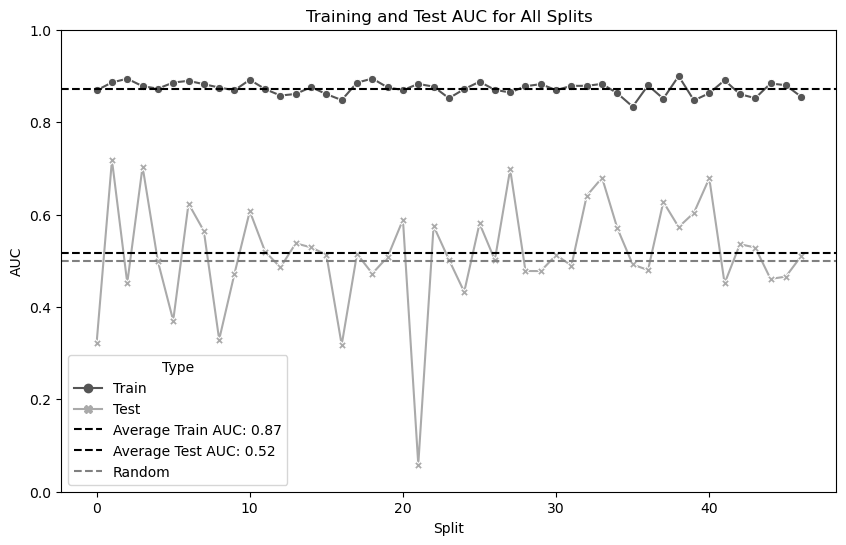

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_aucs' and 'test_aucs' are lists of AUC scores
splits = np.arange(len(train_aucs))  # Assuming splits are sequential and equal to the length of AUC lists

# Prepare a DataFrame for Seaborn
data = pd.DataFrame({
    'Split': np.concatenate([splits, splits]),  # Double the splits for train and test
    'AUC': np.concatenate([train_aucs, test_aucs]),  # Combine AUC scores
    'Type': ['Train']*len(train_aucs) + ['Test']*len(test_aucs)  # Label types
})

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Set the color palette to black and white
palette = sns.color_palette("gray", n_colors=2)

# Draw a line plot with Seaborn
sns.lineplot(data=data, x='Split', y='AUC', hue='Type', style='Type', markers=True, dashes=False, palette=palette)

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='black', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='black', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random chance performance
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

# Customize the axes and title
plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')

# Show the legend and customize it to not show the color guide
plt.legend(title='Type')

# Set the ylim to standardize the AUC view
plt.ylim([0, 1])

# Display the plot
plt.show()


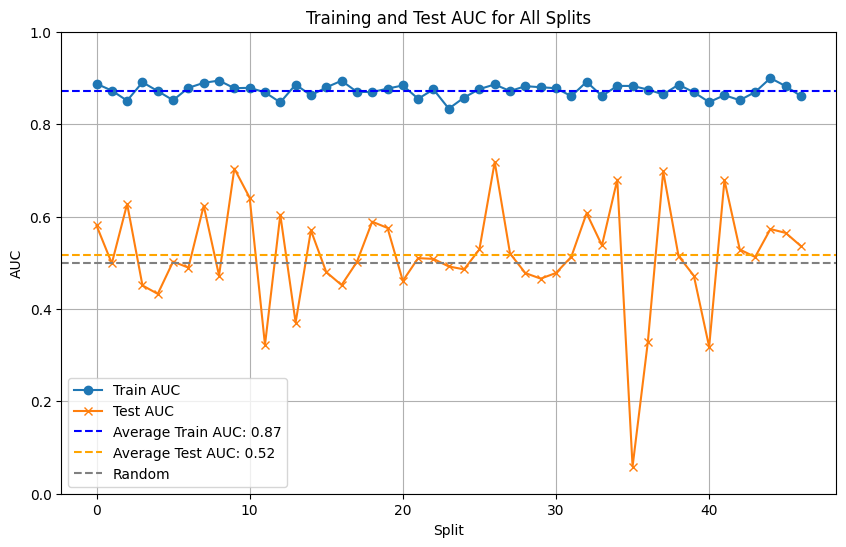

In [16]:
import matplotlib.pyplot as plt

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

plt.figure(figsize=(10, 6))
plt.plot(train_aucs, label="Train AUC", marker='o')
plt.plot(test_aucs, label="Test AUC", marker='x')

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='blue', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='orange', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()
